# Benchmark of the LEMONS Algorithm for Longitudinal Trajectory Component Rebroadcasting

Linear Extrapolation over Mean-subtracted ObservatioNS is an algorithm that performs linear extrapolation of the mean-subtracted longitudinal component of the trajectory. LEMONS exclusively deals with mean-subtracted trajectories (TSM). The broadcaster will broadcast the "velocity" of TSM. The receiver (knowing the mean trajectory in advance), will combine the received velocity value to reconstruct the original trajectory.

In [1]:
%load_ext autoreload
%autoreload 2

import sys 
sys.path.append("/Users/thinhhoang/Documents/anomaly-detection-ngsim")
# sys.path.append("C:\\Users\\nxf67027\\Documents\\anomaly-detection-ngsim")
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

# Data loading, and visualization

In [2]:
import numpy as np
import pickle 
from matplotlib import pyplot as plt 
trajectory_file = open("../spherical-code-paper/trajectories.pyo", "rb")
trajs = pickle.load(trajectory_file)
container_y_np = np.array(trajs['y_vec'])
container_t_np = np.array(trajs['t_vec'])
del trajs
trajectory_file.close()
del trajectory_file
num_of_trajs = container_y_np.shape[0]

In [3]:
# import pickle

# with open('../pwms_spherical/prepare_trajectories.pkl', 'rb') as handle:
#     pkl_obj = pickle.load(handle)
#     container_t_np = pkl_obj['t']
#     container_x_np = pkl_obj['x']
#     container_y_np = pkl_obj['y']
#     print('Data loaded from file')

# num_of_trajs = container_y_np.shape[0]
# traj_length = 270

Text(0.5, 1.0, 'Y')

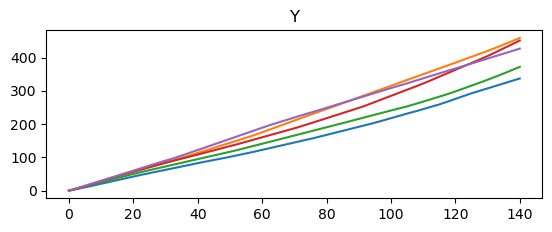

In [4]:
selected_indices_to_plot = np.random.choice(num_of_trajs, 5, replace=False)
plt.title('X')
plt.subplot(2, 1, 1)
for i in selected_indices_to_plot:
    plt.plot(container_y_np[i, :])
plt.title('Y')

# Finding the mean

In [5]:
y_mean = np.mean(container_y_np, axis=0)
# x_mean = np.mean(container_x_np, axis=0)

Text(0.5, 1.0, 'Y')

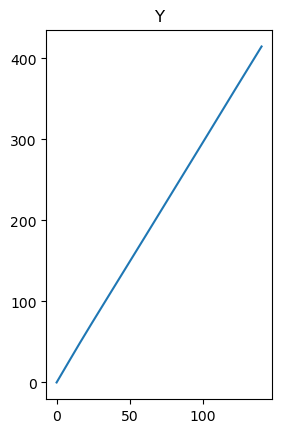

In [6]:
#plt.subplot(1, 2, 1)
#plt.plot(x_mean)
#plt.title('X')
plt.subplot(1, 2, 1)
plt.plot(y_mean)
plt.title('Y')

# Broadcast algorithm

In [7]:
y_mat = container_y_np - y_mean
# x_mat = container_x_np - x_mean

In [8]:
y_vel = np.diff(y_mat, axis=1)
# x_vel = np.diff(x_mat, axis=1)

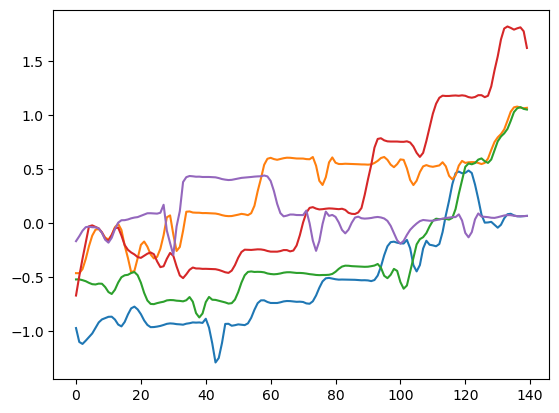

In [9]:
for i in selected_indices_to_plot:
    plt.plot(y_vel[i, :])

Note that the LEMONS algorithm assumes constant residual velocity most of the time. This chart should be able to reflect that.

# Receive algorithm

In [10]:
# Create the known residual velocity to the receiver
y_vel_transmit = np.zeros_like(y_vel)
#x_vel_transmit = np.zeros_like(x_vel) # not used at the moment
y_transmit = np.zeros_like(y_mat)
# x_transmit = np.zeros_like(x_mat) # not used at the moment
traj_length = y_vel.shape[1]
rebroadcast_threshold = 3. # ft
num_of_rebroadcasts = np.zeros((num_of_trajs,))
delta_t_until_rebroadcasts = []

for i in range(num_of_trajs):
    y_vel_transmit[i, 0] = y_vel[i, 0]
    y_transmit[i, 0] = y_mat[i, 0]
    delta_t_until_rebroadcasts_of_this_trajectory = []
    for t in range(1, traj_length):
        # first: try to predict the position at the next time step using the latest velocity value
        y_hat_at_t = y_transmit[i, t-1] + y_vel_transmit[i, t-1]
        # if the error between y_hat_at_t and y_mat[i, t] is larger than rebroadcast_threshold,
        # then rebroadcast the latest velocity value
        if np.abs(y_hat_at_t - y_mat[i, t]) > rebroadcast_threshold:
            y_vel_transmit[i, t] = y_vel[i, t]
            y_hat_at_t = y_mat[i, t]
            num_of_rebroadcasts[i] += 1
            if len(delta_t_until_rebroadcasts_of_this_trajectory) > 0:
                delta_t_until_rebroadcasts_of_this_trajectory.append(t - delta_t_until_rebroadcasts_of_this_trajectory[-1])
            else:
                delta_t_until_rebroadcasts_of_this_trajectory.append(t)
        else:
            y_vel_transmit[i, t] = y_vel_transmit[i, t-1]
        y_transmit[i,t] = y_hat_at_t
    delta_t_until_rebroadcasts.append(delta_t_until_rebroadcasts_of_this_trajectory)

In [11]:
# un-nest the list
delta_t_until_rebroadcasts = [item for sublist in delta_t_until_rebroadcasts for item in sublist]

Average number of rebroadcasts: 4.63
Standard deviation of number of rebroadcasts: 1.5010329776523899


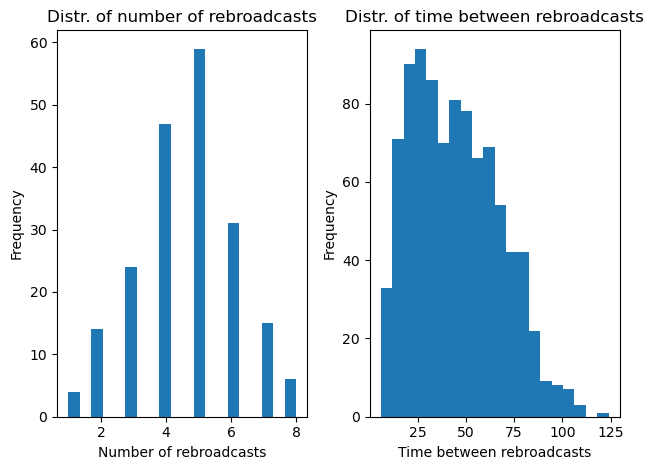

In [12]:
print('Average number of rebroadcasts: {}'.format(np.mean(num_of_rebroadcasts)))
print('Standard deviation of number of rebroadcasts: {}'.format(np.std(num_of_rebroadcasts)))
plt.subplot(1, 2, 1)
plt.hist(num_of_rebroadcasts, bins=20)
plt.title('Distr. of number of rebroadcasts')
plt.xlabel('Number of rebroadcasts')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
plt.hist(delta_t_until_rebroadcasts, bins=20)
plt.title('Distr. of time between rebroadcasts')
plt.xlabel('Time between rebroadcasts')
plt.ylabel('Frequency')
plt.tight_layout()

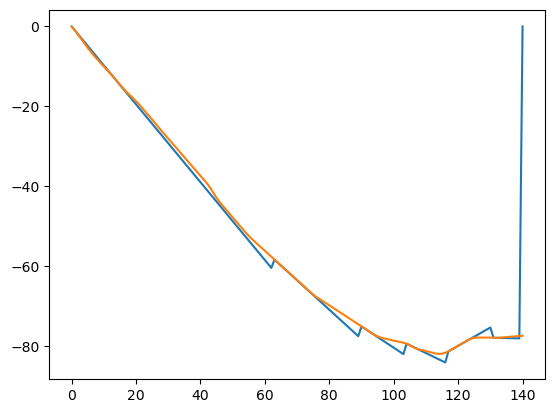

In [13]:
for i in selected_indices_to_plot[:1]:
    plt.plot(y_transmit[i, :])
    plt.plot(y_mat[i, :])